In [22]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import lightning as pl
import torchmetrics
import comet_ml
from lightning.pytorch import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from comet_ml import Experiment


## CUDA SETUP

In [23]:
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.set_default_dtype(torch.float32)
    else:
        device = torch.device('cpu')
        torch.set_default_dtype(torch.float32)
    return device

device = setup_device()
print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Using cuda device


## DATASET

In [24]:
transform = transforms.Compose([
    # transforms.RandomRotation(10),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Values calculated from the ImageNet dataset
])

class Dataset(Dataset):
    def __init__(self, root_dir, dataset_type, transform=None):
        self.root_dir = root_dir
        self.dataset_type = dataset_type
        self.transform = transform
        self.classes_to_ignore = ["del", "nothing", "space"]

        self.classes = sorted([class_name for class_name in os.listdir(self.root_dir) if class_name not in self.classes_to_ignore])


        # self.classes if a dataset type is "test"
        if self.dataset_type == "test":
            test_classes = []
            for class_ in self.classes:
                if class_.endswith(".jpg"):
                    class_name = class_.replace("_test.jpg", "")
                elif class_.endswith(".png"):
                    class_name = class_.replace("_test.png", "")
                if class_name not in self.classes_to_ignore:
                    test_classes.append(class_name)
            self.classes = test_classes

        # Maping class names to numbers 
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes) if class_name not in self.classes_to_ignore}

    def __len__(self):
        if self.dataset_type == "train":
            dataset_len = sum([len(os.listdir(self.root_dir + class_)) for class_ in self.classes])
        elif self.dataset_type == "test":
            dataset_len = len(self.classes)
        return dataset_len
    
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("Index out of bounds")
        
        if self.dataset_type == "train":
            items_in_class = 3000 # Every class has 3000 items
            class_ = self.classes[index // items_in_class]
            image_path = os.path.join(self.root_dir, class_) + f"/{class_}{index % (items_in_class)+1}.jpg"
            # Applying label maping 
            label = self.class_to_idx[class_]
            
        elif self.dataset_type == "test":
            class_ = self.classes[index]
            image_path = os.path.join(self.root_dir, class_) + f"_test.jpg"
            # Applying label maping 
            label = self.class_to_idx[class_]

        # Loading image with cv2
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        # Converting to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # Transform
        if self.transform:
            image = self.transform(Image.fromarray(image))
        
        return image, label
        

In [25]:
# Train dataset and dataloader initialization
train_dataset = Dataset(root_dir="./dataset/asl_alphabet_train/", 
                        transform=transform,
                        dataset_type="train")

Dataset len:
78000

Dataset classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Random images from dataset:


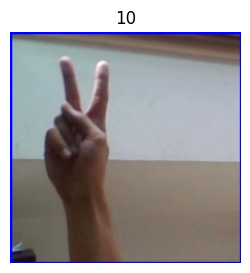

In [26]:
# Sanity check
print("Dataset len:")
print(len(train_dataset))

print("\nDataset classes:")
print(train_dataset.classes)

print("\nRandom images from dataset:")
img, label = train_dataset[random.randint(0, len(train_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()


In [27]:
# Train dataset and dataloader initialization
test_dataset = Dataset(root_dir="./dataset/asl_alphabet_test/", 
                        transform=transform,
                        dataset_type="test")

Dataset len:
26

Dataset classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Random image from dataset:


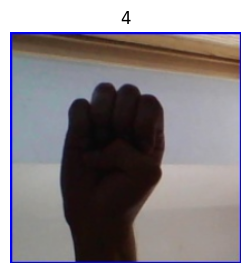

In [28]:
# Sanity check
print("Dataset len:")
print(len(test_dataset))

print("\nDataset classes:")
print(test_dataset.classes)

print("\nRandom image from dataset:")
img, label = test_dataset[random.randint(0, len(test_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()

## SPLITING DATA INTO TRAINING AND VALIDATION DATASETS

In [29]:
train_len = round(0.7 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_len, val_len, train_len + val_len == len(train_dataset)

(54600, 23400, True)

In [30]:
train_dataset_, val_dataset = random_split(train_dataset, [train_len, val_len])

In [31]:
# Sanity check once more

print(f"Number of training samples: {len(train_dataset_)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of train classes: {len(train_dataset_.dataset.classes)}")
print(f"Number of val classes: {len(val_dataset.dataset.classes)}")
print(f"Number of test samples: {len(test_dataset)}") 


Number of training samples: 54600
Number of validation samples: 23400
Number of train classes: 26
Number of val classes: 26
Number of test samples: 26


In [32]:
print(f"Train dataset classes: {train_dataset.classes}")
print(f"Validation dataset classes: {train_dataset.classes}")
print(f"Class-to-index mapping: {train_dataset.class_to_idx}")

Train dataset classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Validation dataset classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Class-to-index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


## DATALOADERS

In [33]:
import os
num_workers = os.cpu_count()
print(f"Suggested num_workers: {num_workers}")

Suggested num_workers: 24


In [34]:
train_dataloader = DataLoader(train_dataset_,
                              batch_size=32,
                              shuffle=True,
                              num_workers=0)

val_dataloader = DataLoader(val_dataset,
                            batch_size=32,
                            shuffle=False,
                            num_workers=0)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=32, 
                             shuffle=False, 
                             num_workers=0)


In [35]:
import multiprocessing as mp
print(f"Number of CPUs: {mp.cpu_count()}")

Number of CPUs: 24


In [36]:
# Sanity check
def loader_sanity_check(loader):
    for batch_idx, (data, labels) in enumerate(loader):
        print(f"Batch nr: {batch_idx}")
        print(f"Batch size: {data.shape[0]}")
        print(f"Data shape: {data.shape}")
        print(f"Image shape: {data[0].shape}")
        print(f"Classes: {labels}")
        print(f"Num classes: {len(labels)}")
        break

In [37]:
loader_sanity_check(train_dataloader) 

Batch nr: 0
Batch size: 32
Data shape: torch.Size([32, 3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Classes: tensor([13, 13, 12, 13, 23,  7, 24, 21,  3, 24,  6, 11, 14,  2,  6, 24, 10, 12,
        22, 16,  4,  0, 23, 20,  4, 11, 11,  5, 12, 21,  9, 14])
Num classes: 32


In [38]:
loader_sanity_check(val_dataloader) 

Batch nr: 0
Batch size: 32
Data shape: torch.Size([32, 3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Classes: tensor([ 4, 11, 12,  6,  7, 17, 22, 20, 11,  1,  8, 21, 17, 19,  4,  0, 14, 13,
         7, 16,  0, 24, 19, 19, 14,  3, 19,  8, 25, 12,  5,  4])
Num classes: 32


In [39]:
loader_sanity_check(test_dataloader)

Batch nr: 0
Batch size: 26
Data shape: torch.Size([26, 3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])
Num classes: 26


## CUSTOM CNN

In [40]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        self.model = nn.Sequential(
            # Pierwsza warstwa splotowa
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Rozmiar zmniejsza się: 224x224 -> 112x112
            
            # Druga warstwa splotowa
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Rozmiar zmniejsza się: 112x112 -> 56x56
            
            # Trzecia warstwa splotowa
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Rozmiar zmniejsza się: 56x56 -> 28x28
            
            # Czwarta warstwa splotowa
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Rozmiar zmniejsza się: 28x28 -> 14x14
            
            # Piąta warstwa splotowa
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Rozmiar zmniejsza się: 14x14 -> 7x7
            
            # Spłaszczenie
            nn.Flatten(),
            
            # Warstwy w pełni połączone
            nn.Linear(256 * 7 * 7, 512),  # 256 kanałów, każdy o rozmiarze 7x7
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, num_classes)  # Liczba wyjściowych klas
        )

    def forward(self, x):
        return self.model(x)


In [41]:
num_classes = len(train_dataset.classes)
custom_model = CustomCNN(num_classes=num_classes)

print(custom_model)


CustomCNN(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=12544, out_f

In [42]:
total_params = sum(p.numel() for p in custom_model.parameters())
trainable_params = sum(p.numel() for p in custom_model.parameters() if p.requires_grad)
frozen_params = sum(p.numel() for p in custom_model.parameters() if not p.requires_grad)

print(f"All parameters: {total_params}")
print(f"Frozen parameters: {frozen_params}")
print(f"Trainable parameters: {trainable_params}")


All parameters: 6828986
Frozen parameters: 0
Trainable parameters: 6828986


## COMET_ML SETUP

In [43]:
from comet_ml import Experiment

# Initialize Comet.ml experiment
experiment = Experiment(
    api_key=os.getenv("COMET_API_KEY"),
    project_name="DLF-sign_letters_classification",
)

experiment.set_name("Custom CNN")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ziemmi13/dlf-sign-letters-classification/54ae6442ea194e82926967333394c271



## Define helper functions to logs gradients and weights

In [44]:
def to_numpy(x):
    return x.detach().numpy()


def update_gradient_map(model, gradmap):
    for name, layer in zip(model._modules, model.children()):
        if "activ" in name:
            continue

        if not hasattr(layer, "weight"):
            continue

        wname = "%s/%s.%s" % ("gradient", name, "weight")
        bname = "%s/%s.%s" % ("gradient", name, "bias")

        gradmap.setdefault(wname, 0)
        gradmap.setdefault(bname, 0)

        gradmap[wname] += layer.weight.grad
        gradmap[bname] += layer.bias.grad

    return gradmap


def log_gradients(gradmap, step):
    for k, v in gradmap.items():
        experiment.log_histogram_3d(to_numpy(v), name=k, step=step)


def log_weights(model, step):
    for name, layer in zip(model._modules, model.children()):
        if "activ" in name:
            continue

        if not hasattr(layer, "weight"):
            continue

        wname = "%s.%s" % (name, "weight")
        bname = "%s.%s" % (name, "bias")

        experiment.log_histogram_3d(to_numpy(layer.weight), name=wname, step=step)
        experiment.log_histogram_3d(to_numpy(layer.bias), name=bname, step=step)

## MODEL PARAMETERS

In [45]:
learning_rate = 0.0001
batch_size = 32
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=learning_rate, weight_decay=1e-4) # https://paperswithcode.com/method/weight-decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3) # https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
num_epochs = 5

hyper_params = {"batch_size": batch_size, "num_epochs": num_epochs, "learning_rate": learning_rate}
experiment.log_parameters(hyper_params)

In [46]:
def train_model(device, model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    model.to(device)

    print(f"Starting Training")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate batch loss (not divided by dataset size)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

           # Log every 50 batches
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
                experiment.log_metric("train_loss", loss.item(), step=batch_idx + len(train_dataloader) * (epoch))

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)  # Average loss per batch
        train_accuracy = 100. * train_correct / train_total
        train_losses.append(epoch_loss)

        # Log epoch metrics
        experiment.log_metric("epoch_train_loss", epoch_loss, step=epoch)
        experiment.log_metric("epoch_train_accuracy", train_accuracy, step=epoch)

        val_losses = []
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        

        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(val_epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        print('-' * 60)

        # Log validation metrics
        experiment.log_metric("val_loss", val_epoch_loss, step=epoch)
        experiment.log_metric("val_accuracy", val_accuracy, step=epoch)

    return train_losses, val_losses

In [47]:
# Test loop
def test_model(device, model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Log test metrics
    experiment.log_metric("test_loss", test_loss)
    experiment.log_metric("test_accuracy", test_accuracy)

    return test_loss, test_accuracy

## TRAINING

In [48]:
train_losses, val_losses = train_model(device, custom_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

Starting Training
Epoch: 1, Batch: 0, Loss: 3.2549
Epoch: 1, Batch: 100, Loss: 3.1227
Epoch: 1, Batch: 200, Loss: 3.0603
Epoch: 1, Batch: 300, Loss: 2.6620
Epoch: 1, Batch: 400, Loss: 1.6216
Epoch: 1, Batch: 500, Loss: 1.8947
Epoch: 1, Batch: 600, Loss: 1.6443
Epoch: 1, Batch: 700, Loss: 1.4722
Epoch: 1, Batch: 800, Loss: 1.5705
Epoch: 1, Batch: 900, Loss: 0.9416
Epoch: 1, Batch: 1000, Loss: 0.8880
Epoch: 1, Batch: 1100, Loss: 0.8605
Epoch: 1, Batch: 1200, Loss: 0.6758
Epoch: 1, Batch: 1300, Loss: 0.4742
Epoch: 1, Batch: 1400, Loss: 0.8353
Epoch: 1, Batch: 1500, Loss: 0.6566
Epoch: 1, Batch: 1600, Loss: 0.6920
Epoch: 1, Batch: 1700, Loss: 0.5177
Epoch [1/5]
Training Loss: 1.4322, Training Accuracy: 54.99%
Validation Loss: 0.3596, Validation Accuracy: 89.10%
------------------------------------------------------------
Epoch: 2, Batch: 0, Loss: 0.6079
Epoch: 2, Batch: 100, Loss: 0.6976
Epoch: 2, Batch: 200, Loss: 0.4275
Epoch: 2, Batch: 300, Loss: 0.3178
Epoch: 2, Batch: 400, Loss: 0.384

In [59]:
# Saving model and weights
torch.save(custom_model, "./models/Custom_CNN_test1_model")
torch.save(custom_model.state_dict(), "./models/Custom_CNN_test1_weights")

## Log the Model to Comet

In [50]:
from comet_ml.integration.pytorch import log_model

log_model(experiment, custom_model, "Custom_CNN - sign letters classification")

## End Experiment

In [51]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Custom CNN
COMET INFO:     url                   : https://www.comet.com/ziemmi13/dlf-sign-letters-classification/54ae6442ea194e82926967333394c271
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch_train_accuracy [5] : (54.98717948717949, 96.95054945054945)
COMET INFO:     epoch_train_loss [5]     : (0.09118821820248012, 1.4322436160086607)
COMET INFO:     train_loss [90]          : (0.0037275853101164103, 3.254934310913086)
COMET INFO:     val_accuracy [5]         : (89.1025641025641, 99.3974358974359)
COMET INFO:     val_loss [5]             : (0.019040703146116167, 0.3595938748104976)
COMET INFO:   Others:
COMET INFO:     Name : Custo

## TESTING

In [52]:
test_loss, test_accuracy = test_model(device, custom_model, test_dataloader, criterion)

Test Loss: 0.0000, Test Accuracy: 100.00%


In [60]:
loaded_model = torch.load(f="./models/Custom_CNN_test1_model", weights_only=False)
loaded_model.to(device)
print(loaded_model)


CustomCNN(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=12544, out_f

In [58]:
from PIL import Image
from torchvision import transforms

# Funkcja do przewidywania klasy pojedynczego obrazu
def predict_image(image_path, model, device, class_names):
    # Wczytanie i przetworzenie obrazu
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Rozmiar wejścia dla ResNet50
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizacja ImageNet
    ])

    image = Image.open(image_path).convert('RGB')  # Konwersja na RGB
    image_tensor = transform(image).unsqueeze(0).to(device)  # Dodanie wymiaru wsadowego

    model.to(device)
    # Przewidywanie
    model.eval()
    with torch.inference_mode():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)

    # Zwracanie nazwy klasy
    predicted_class = class_names[predicted.item()]
    return predicted_class

# Przykład użycia
image_path = "./dataset/test_images/test_image#8.png"
class_names = train_dataset.classes  # Zakładając, że masz listę klas
predicted_class = predict_image(image_path, custom_model, device, class_names)

print(f"Predicted class: {predicted_class}")


Predicted class: G
